In [68]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.preprocessing import *

import lightgbm as lgb
print(lgb.__version__)



4.5.0


In [69]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [70]:
x = df.drop('mortality',axis=1)
y = df.mortality.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

#scaler = RobustScaler(unit_variance=True)
scaler = QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)
#scaler = PowerTransformer(method='yeo-johnson', standardize=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [71]:


lgb_train = lgb.Dataset(x_train, y_train)#params={'feature_pre_filter':False})
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)#params={'feature_pre_filter':False})




In [75]:
lgbm_params = {
        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 100,
        
}
params = {
    "objective": "binary",
    "metric":  "auc",
    "verbosity": 1,
    "boosting_type": "gbdt",
    #"max_depth" : -1,
    #"num_leaves" : -1,
    "learning_rate" : 0.03,
   # "lambda_l1":0,
   # "lambda_l2": 2.,
    #"bagging_fraction":0.9,
    #"feature_fraction":1.0,
   # "max_bin":35,
    'is_unbalance':True,
}

def sigmoid(x):
  return 1/(1+np.exp(-x))

# Define the F1 Score metric
def F1_metric(y_pred,dataset):
  y_true=dataset.get_label()
  p = sigmoid(y_pred)
  labels = (p>0.5).astype(int)
  F1 = f1_score(y_true, labels)
  return "F1",F1,True

eval_result = {}
early_stopping_callback = lgb.callback.early_stopping(stopping_rounds=100)#, metric='F1')
record_evaluation_callback = lgb.callback.record_evaluation(eval_result =eval_result )

model = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train,lgb_test],
    num_boost_round=10000,
    feval = F1_metric,
    callbacks=[early_stopping_callback, record_evaluation_callback]
)

[LightGBM] [Info] Number of positive: 961, number of negative: 2991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.243168 -> initscore=-1.135389
[LightGBM] [Info] Start training from score -1.135389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.762408	training's F1: 0.391207	valid_1's auc: 0.63796	valid_1's F1: 0.422522


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

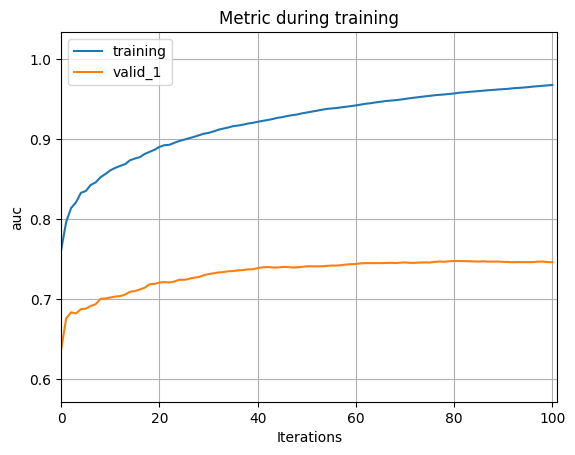

In [76]:
lgb.plot_metric(eval_result,metric='auc')

Accuracy: 0.268
Precision: 0.268
Recall: 1.000
F1 Score: 0.423
AUC score: 0.638 



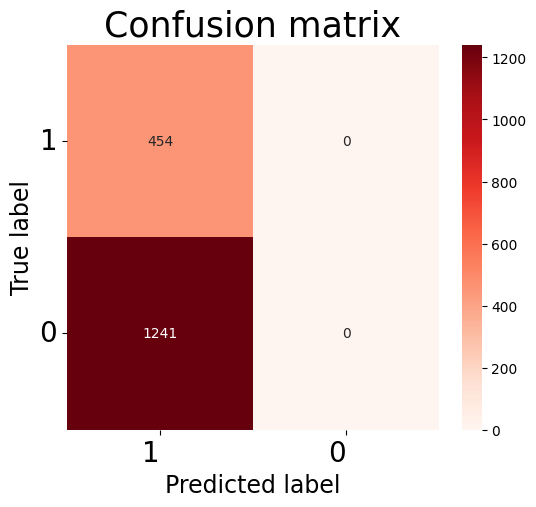

In [77]:
from util import *
y_pred = model.predict(x_test)
p = sigmoid(y_pred)
y_label = (p>0.5).astype(int)
evaluate_model(y_test, y_label, p)